In [2]:
import numpy as np
import pandas as pd
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
from scipy.signal import savgol_filter as savgol

In [162]:
datadir = 'Exps/isovisc-immisc-disp-unstable/beta75At125/Exp19GPH5/scaled_images.mat'
scaled_images = sio.loadmat(datadir)
scaled_images = scaled_images['scaled_im_cam0']
# the first dimension is number of pixels in spanwise, second dim is number of pixels in 
# streamwise dir, and third dim is number of snapshots


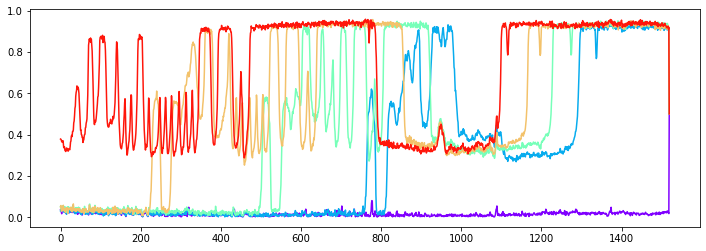

In [165]:
# average in spanwise direction for plotting to check for anomalies
span_avg_images = np.mean(scaled_images,axis=0)
window_size,polyorder=3,1
# span_avg_images = savgol(span_avg_images,window_size,polyorder,axis=1)

# cmap stuff
n_lines = span_avg_images.shape[1] 
c = np.arange(1, n_lines + 1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.rainbow)
cmap.set_array([])

# use this figure to check if the some pixels in the x-dir need to be removed 
# or if some timepoints need to be removed
plt.figure(figsize=(12,4));
for tt in range(0,span_avg_images.shape[1],40): # plotting the avg conc for all time in each x
    plt.plot(span_avg_images[:,tt],c=cmap.to_rgba(tt));

# beta0/Exp30_Re703 has some artifact at the last few columns, removing them
data = scaled_images[:,:,:]
nY,nX,nT = scaled_images.shape

In [166]:
# snapshot matrix
X = scaled_images.reshape(nY*nX,nT)
Xp = X[:,0:-1]
Xf = X[:,1:]
print(X.shape)

(25840, 165)


In [167]:
# SVD enhanced DMD
U,s,Vh = np.linalg.svd(Xp)

dynamics truncated to rank r = 160


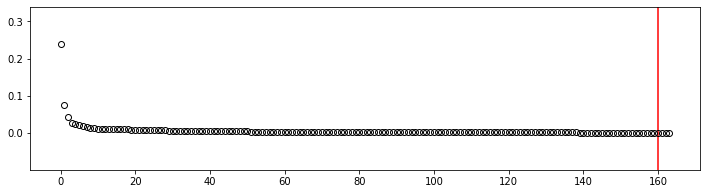

In [225]:
# r = np.minimum(U.shape[1],Vh.shape[0]) # this is the quick and dirty approach
sv_thresh = 0.01 # max normalized singular values are kept if greater than sv_thresh
s_var = s/s.sum()
r = np.max(np.nonzero((s_var > sv_thresh))[0]) + 1 
r = 160

plt.figure(figsize=(12,3));
plt.plot(s_var,'o',mfc='None',mec='black');
plt.vlines(r,-10,1100,color='red');
plt.ylim(s_var.min()-0.1,s_var.max()+0.1);

print('dynamics truncated to rank r =',r)

In [226]:
U_r = U[:,0:r] # truncate to rank-r
s_r = s[0:r]
Vh_r = Vh[0:r,:]
Atilde = U_r.T @ Xf @ Vh_r.T @ np.diag(1/s_r) # low-rank dynamics

In [227]:
# eigendecomposition of Atilde
eVals,eVecs = np.linalg.eig(Atilde)
# DMD modes
Phi = Xf @ Vh_r.T @ np.diag(1/s_r) @ eVecs
Phi_real = np.real(Phi)

In [228]:
# define the energy content (or power) of the modes as λ_j^{nT−1}||mode_j||
Phi_power = eVals**(nT-1)*np.linalg.norm(Phi,ord=2,axis=0)
max_power_inds = np.absolute(Phi_power).argsort()[-r:][::-1]

In [229]:
def plot_eigvals(matrix):
    theta = np.linspace(0,20,100)
    L = np.linalg.eigvals(matrix)
    plt.figure();
    plt.plot(np.real(L),np.imag(L),'o');
    plt.plot(np.cos(theta),np.sin(theta),color='black',alpha=0.3)
    plt.axis('equal');

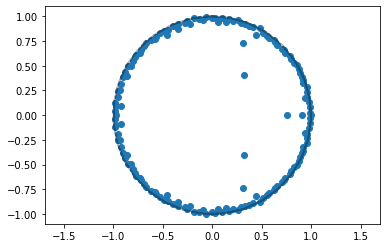

In [230]:
plot_eigvals(Atilde)

### Predictions 

In [231]:
b = np.linalg.pinv(Phi) @ X[:,0:1]

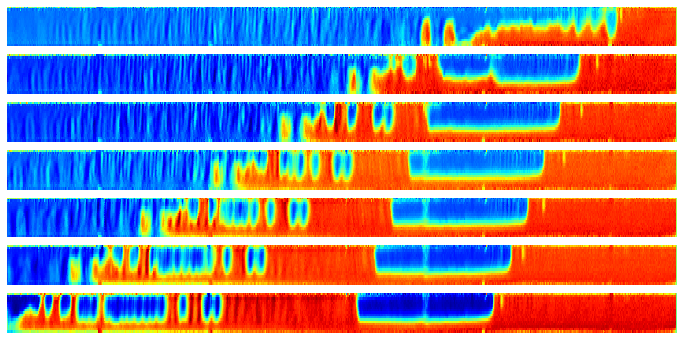

In [232]:
t_pred = np.round(np.linspace(0,X.shape[1],8)) - 10
fig,axs = plt.subplots(nrows=len(t_pred)-1,ncols=1,figsize=(12,6));
for kk,thisax in enumerate(axs.reshape(-1)): 
    x_k = (np.real(Phi @ np.diag(eVals**t_pred[kk+1]) @ b)).reshape(nY,nX)
    sb.heatmap(x_k,cmap='jet',cbar=False,ax=thisax);
    thisax.set_xticks([]);
    thisax.set_yticks([]);
# plt.savefig('one-step-preds.pdf')

### Plotting modes

In [233]:
Phi_real_plot = Phi_real.reshape(nY,nX,r)
cont_eVals = list(np.round(np.log(eVals),3))
cont_eVals = [str(x) for x in cont_eVals]
[str(ii)+':'+cont_eVals[ii] for ii in max_power_inds]

['99:(0.001-1.068j)',
 '98:(0.001+1.068j)',
 '25:0j',
 '39:(-0-0.287j)',
 '38:(-0+0.287j)',
 '136:(-0.004+1.636j)',
 '137:(-0.004-1.636j)',
 '128:(-0.005+1.753j)',
 '129:(-0.005-1.753j)',
 '124:(-0.007+1.304j)',
 '125:(-0.007-1.304j)',
 '62:(-0.009-0.535j)',
 '61:(-0.009+0.535j)',
 '34:(-0.01+0.084j)',
 '35:(-0.01-0.084j)',
 '37:(-0.011-0.132j)',
 '36:(-0.011+0.132j)',
 '59:(-0.011+0.489j)',
 '60:(-0.011-0.489j)',
 '47:(-0.011+0.372j)',
 '48:(-0.011-0.372j)',
 '58:(-0.013-2.313j)',
 '57:(-0.013+2.313j)',
 '64:(-0.013+0.652j)',
 '65:(-0.013-0.652j)',
 '32:(-0.013+0.026j)',
 '33:(-0.013-0.026j)',
 '43:(-0.014-0.238j)',
 '42:(-0.014+0.238j)',
 '138:(-0.014+1.71j)',
 '139:(-0.014-1.71j)',
 '147:(-0.014-1.545j)',
 '146:(-0.014+1.545j)',
 '7:(-0.014+3.016j)',
 '8:(-0.014-3.016j)',
 '119:(-0.015-1.933j)',
 '118:(-0.015+1.933j)',
 '142:(-0.015+1.401j)',
 '143:(-0.015-1.401j)',
 '54:(-0.016-0.445j)',
 '53:(-0.016+0.445j)',
 '22:(-0.016-2.615j)',
 '21:(-0.016+2.615j)',
 '144:(-0.016+1.468j)',
 '

In [234]:
# use the print out above to see which modes to plot
plot_inds = [max_power_inds[0],max_power_inds[2],max_power_inds[4],max_power_inds[6],\
            max_power_inds[8]]

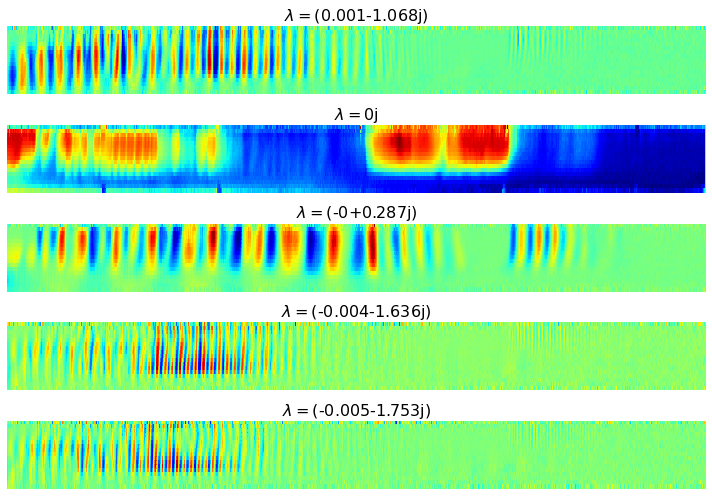

In [235]:
# fig,axs = plt.subplots(nrows=len(max_power_inds),ncols=1,figsize=(15,15))
fig,axs = plt.subplots(nrows=len(plot_inds),ncols=1,figsize=(10,7))
for ii,thisax in enumerate(axs.reshape(-1)):
    sb.heatmap(Phi_real_plot[:,:,plot_inds[ii]],cmap='jet',cbar=False,ax=thisax);
    thisax.set_title(r'$\lambda =$'+cont_eVals[plot_inds[ii]],fontsize=16)
    thisax.set_xticks([]);
    thisax.set_yticks([]);
plt.tight_layout();
# plt.savefig('realmodes.pdf')

### Can the DMD modes explain the diffusion time-scale or coefficient? 